# Ingestion routine

+ The following script outlines the steps to ingest UCLA Miniscope data (acquired metadata and processed data) into the DataJoint `workflow-miniscope`.

+ To ingest with a completely automated workflow, see `03automate.ipynb`.

In [1]:
# Change into the parent directory to find the `dj_local_conf.json` file. 
# When you type `import datajoint as dj` the credentials from `dj_local_conf.json` will be used to log into the database.
import os
os.chdir('..')

In [ ]:
import numpy as np
from workflow_miniscope.pipeline import *

## Schema diagrams

+ The following outputs are the diagrams of the schemas comprising this workflow.

+ Please refer back to these diagrams to visualize the relationships of different tables.

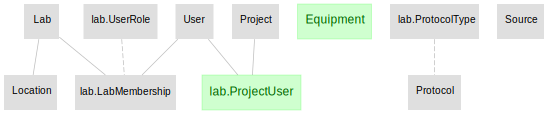

In [4]:
dj.Diagram(lab)

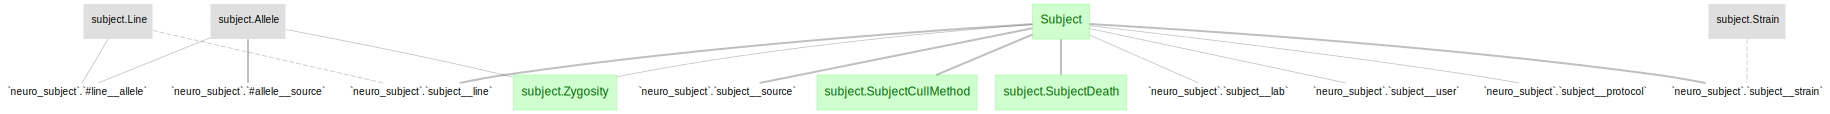

In [5]:
dj.Diagram(subject)

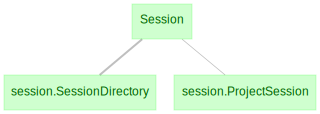

In [6]:
dj.Diagram(session)

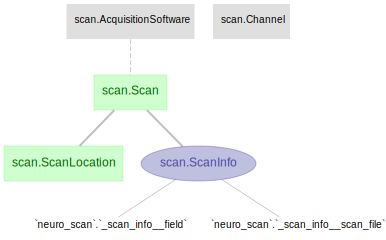

In [7]:
dj.Diagram(scan)

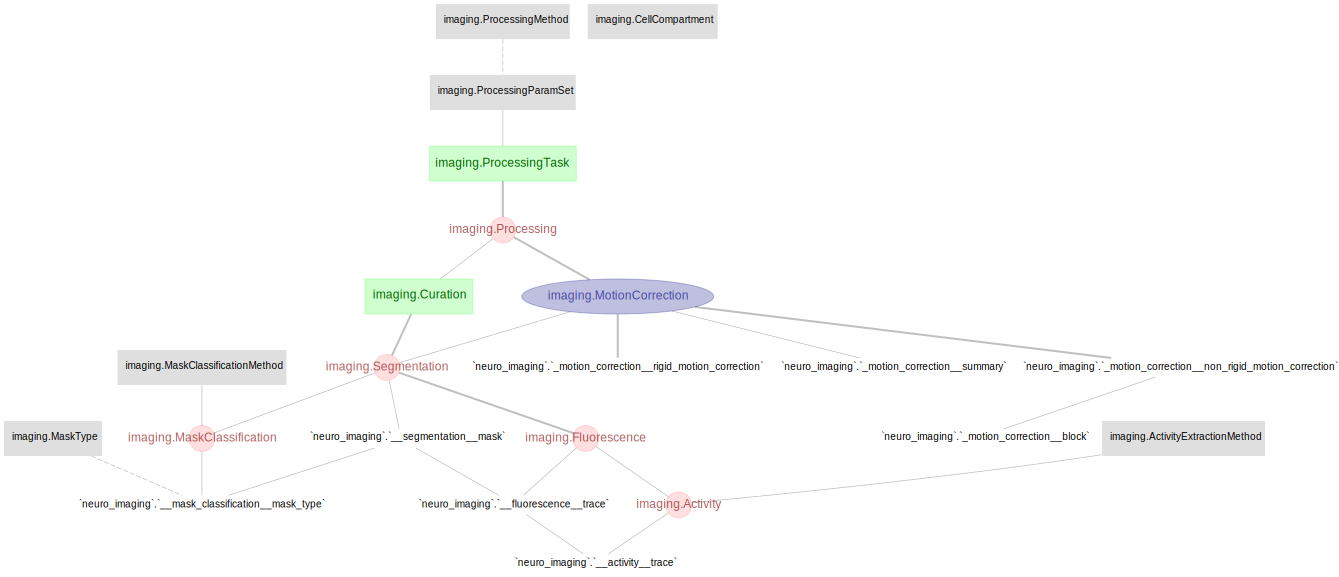

In [8]:
dj.Diagram(imaging)

## Insert an entry into `subject.Subject`

In [9]:
subject.Subject.insert1(dict(subject='subject1', 
                             sex='F', 
                             subject_birth_date='2019-01-01 00:00:01', 
                             subject_description='no description'))

## Insert an entry into `lab.Equipment`

In [10]:
Equipment.insert1(dict(scanner='Miniscope-DAQ-V3'))

## Insert an entry into `session.Session`

In [11]:
session.Session.insert1(dict(subject='subject1', 
                             session_datetime='2021-01-01 00:00:01'))

## Insert an entry into `session.SessionDirectory`

In [12]:
session.SessionDirectory.insert1(dict(subject='subject1', 
                                      session_datetime='2021-01-01 00:00:01', 
                                      session_dir='<imaging_root_data_dir>/subject1/session0'))

## Insert an entry into `scan.Scan`

In [ ]:
scan.Scan.insert1(dict(subject='subject1', 
                       session_datetime='2021-01-01 00:00:01', 
                       scan_id=0, 
                       scanner='Miniscope-DAQ-V3', 
                       acq_software='Miniscope-DAQ-V3',
                       scan_notes=''))

## Populate `scan.ScanInfo`

+ This imported table stores information about the acquired image (e.g. image dimensions, file paths, etc.).
+ `populate` automatically calls `make` for every key for which the auto-populated table is missing data.
+ `populate_settings` passes arguments to the `populate` method.
+ `display_progress=True` reports the progress bar

In [ ]:
populate_settings = {'display_progress': True}

In [ ]:
scan.ScanInfo.populate(**populate_settings)

## Insert an entry into `imaging.ProcessingTask`

+ This entry will trigger ingestion of the processed results (i.e. motion correction, segmentation, and traces)

+ The `paramset_idx` is the parameter set stored in `imaging.ProcessingParamSet` that is used for the image processing.

+ The `processing_output_dir` attribute contains the output directory of the processed results (relative the the imaging root data directory).

In [7]:
imaging.ProcessingTask.insert1(dict(subject='subject1', 
                                    session_datetime='2021-01-01 00:00:01', 
                                    scan_id=0,
                                    paramset_idx=0,
                                    processing_output_dir='<imaging_root_data_dir>/subject1/session0/miniscope_analysis',
                                    task_mode='load'))

## Populate `imaging.Processing`

+ For the `task_mode=load` specified above in `imaging.ProcessingTask`, this step ensures that the output directory contains the valid processed outputs.

+ In the future, this step will provide for the option to `trigger` the analysis within this workflow (if the `task_mode=trigger`).

In [ ]:
imaging.Processing.populate(**populate_settings)

## Populate `imaging.MotionCorrection`

+ This table contains the rigid or non-rigid motion correction data including the shifts and summary images.


In [ ]:
imaging.MotionCorrection.populate(**populate_settings)

## Insert an entry into `imaging.Curation`

+ The next step in the pipeline is the curation of segmentation results. If a manual curation was implemented, an entry needs to be manually inserted into the table Curation, which specifies the directory to the curated results in curation_output_dir. If we would like to process the processed outcome directly, an entry is also needed in Curation. A method create1_from_processing_task was provided to help this insertion. It copies the processing_output_dir in ProcessingTask to the field curation_output_dir in the table Curation with a new curation_id.

+ In this example, we create/insert one `imaging.Curation` for each `imaging.ProcessingTask`, specifying the same output directory.

In [ ]:
imaging.Curation(dict(subject='subject1', 
                      session_datetime='2021-01-01 00:00:01', 
                      scan_id=0,
                      paramset_idx=0,
                      curation_id=0,
                      curation_time='2021-01-01 00:00:01', 
                      curation_output_dir='<imaging_root_data_dir>/subject1/session0/miniscope_analysis',
                      manual_curation=False,
                      curation_note=''})

## Populate `imaging.Segmentation`

+ This table contains the mask coordinates, weights, and centers.

In [ ]:
imaging.Segmentation.populate(**populate_settings)

## Populate `imaging.MaskClassification`

+ This table is currently not implemented.

In [ ]:
imaging.MaskClassification.populate(**populate_settings)

## Populate `imaging.Fluorescence`

+ This table contains the fluorescence traces prior filtering and spike extraction

In [ ]:
imaging.Fluorescence.populate(**populate_settings)

## Populate `imaging.Activity`
+ This table contains the inferred neural activity from the fluorescence traces.

In [ ]:
imaging.Activity.populate(**populate_settings)

## Proceed to the `02explore.ipynb` Jupyter Notebook

+ This notebook describes the steps to query, fetch, and visualize the imaging data.